In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("housing.csv")

In [3]:
print(df.head())
print(df.info())
print(df.isnull().sum())
print(df.describe())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

In [4]:
import math

def plot_all_histograms(df, title_prefix=""):
    num_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3
    n_rows = math.ceil(len(num_cols) / n_cols)

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"{title_prefix}{col}")
        plt.xlabel("")
        plt.ylabel("")

    plt.tight_layout()
    plt.show()

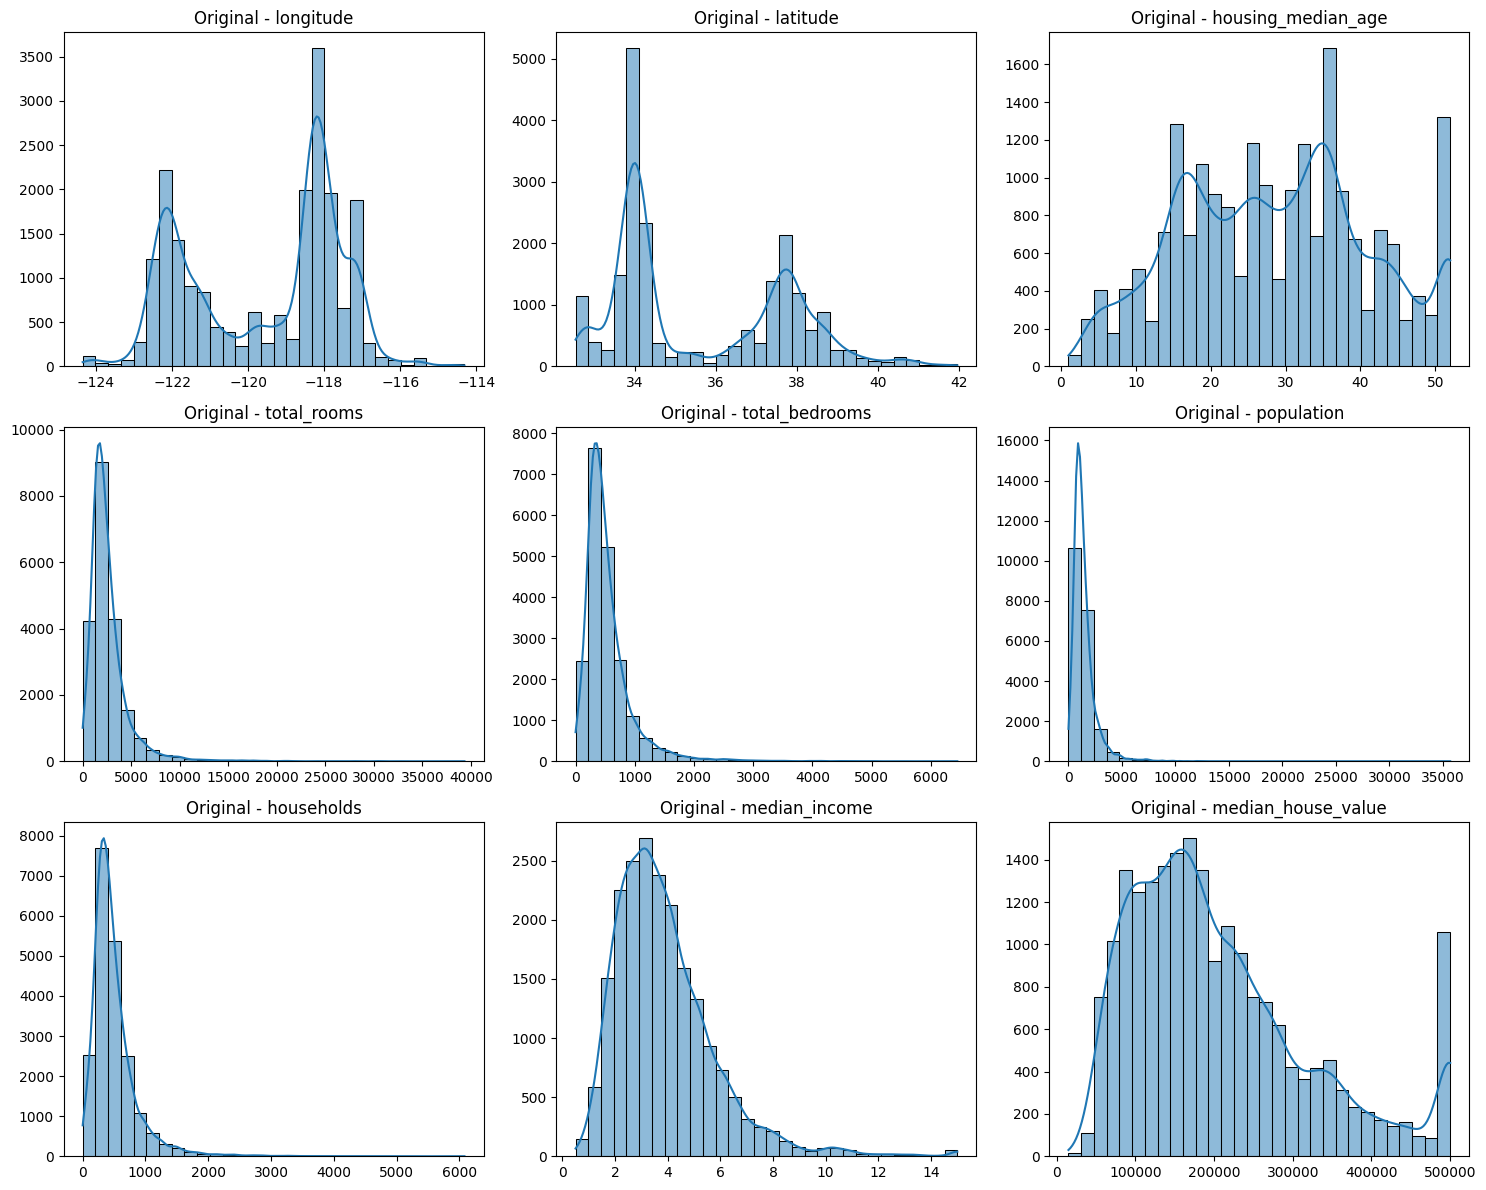

In [5]:
plot_all_histograms(df, title_prefix="Original - ")

In [6]:
from scipy.stats import skew

skews = df.select_dtypes(include=[np.number]).apply(skew).sort_values(ascending=False)
print(skews)

population            4.935500
total_rooms           4.147042
households            3.410190
median_income         1.646537
median_house_value    0.977692
latitude              0.465919
housing_median_age    0.060326
longitude            -0.297780
total_bedrooms             NaN
dtype: float64


In [7]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [9]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [10]:
df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)

In [11]:
X = df.drop("median_house_value", axis = 1)
y = df["median_house_value"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# X'leri yeo-johnsonla  y'yi box-cox'la transform edelim
pt_X = PowerTransformer(method="yeo-johnson")

X_train_transformed = pt_X.fit_transform(X_train)
X_test_transformed = pt_X.transform(X_test)

In [13]:
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns = X_train.columns)

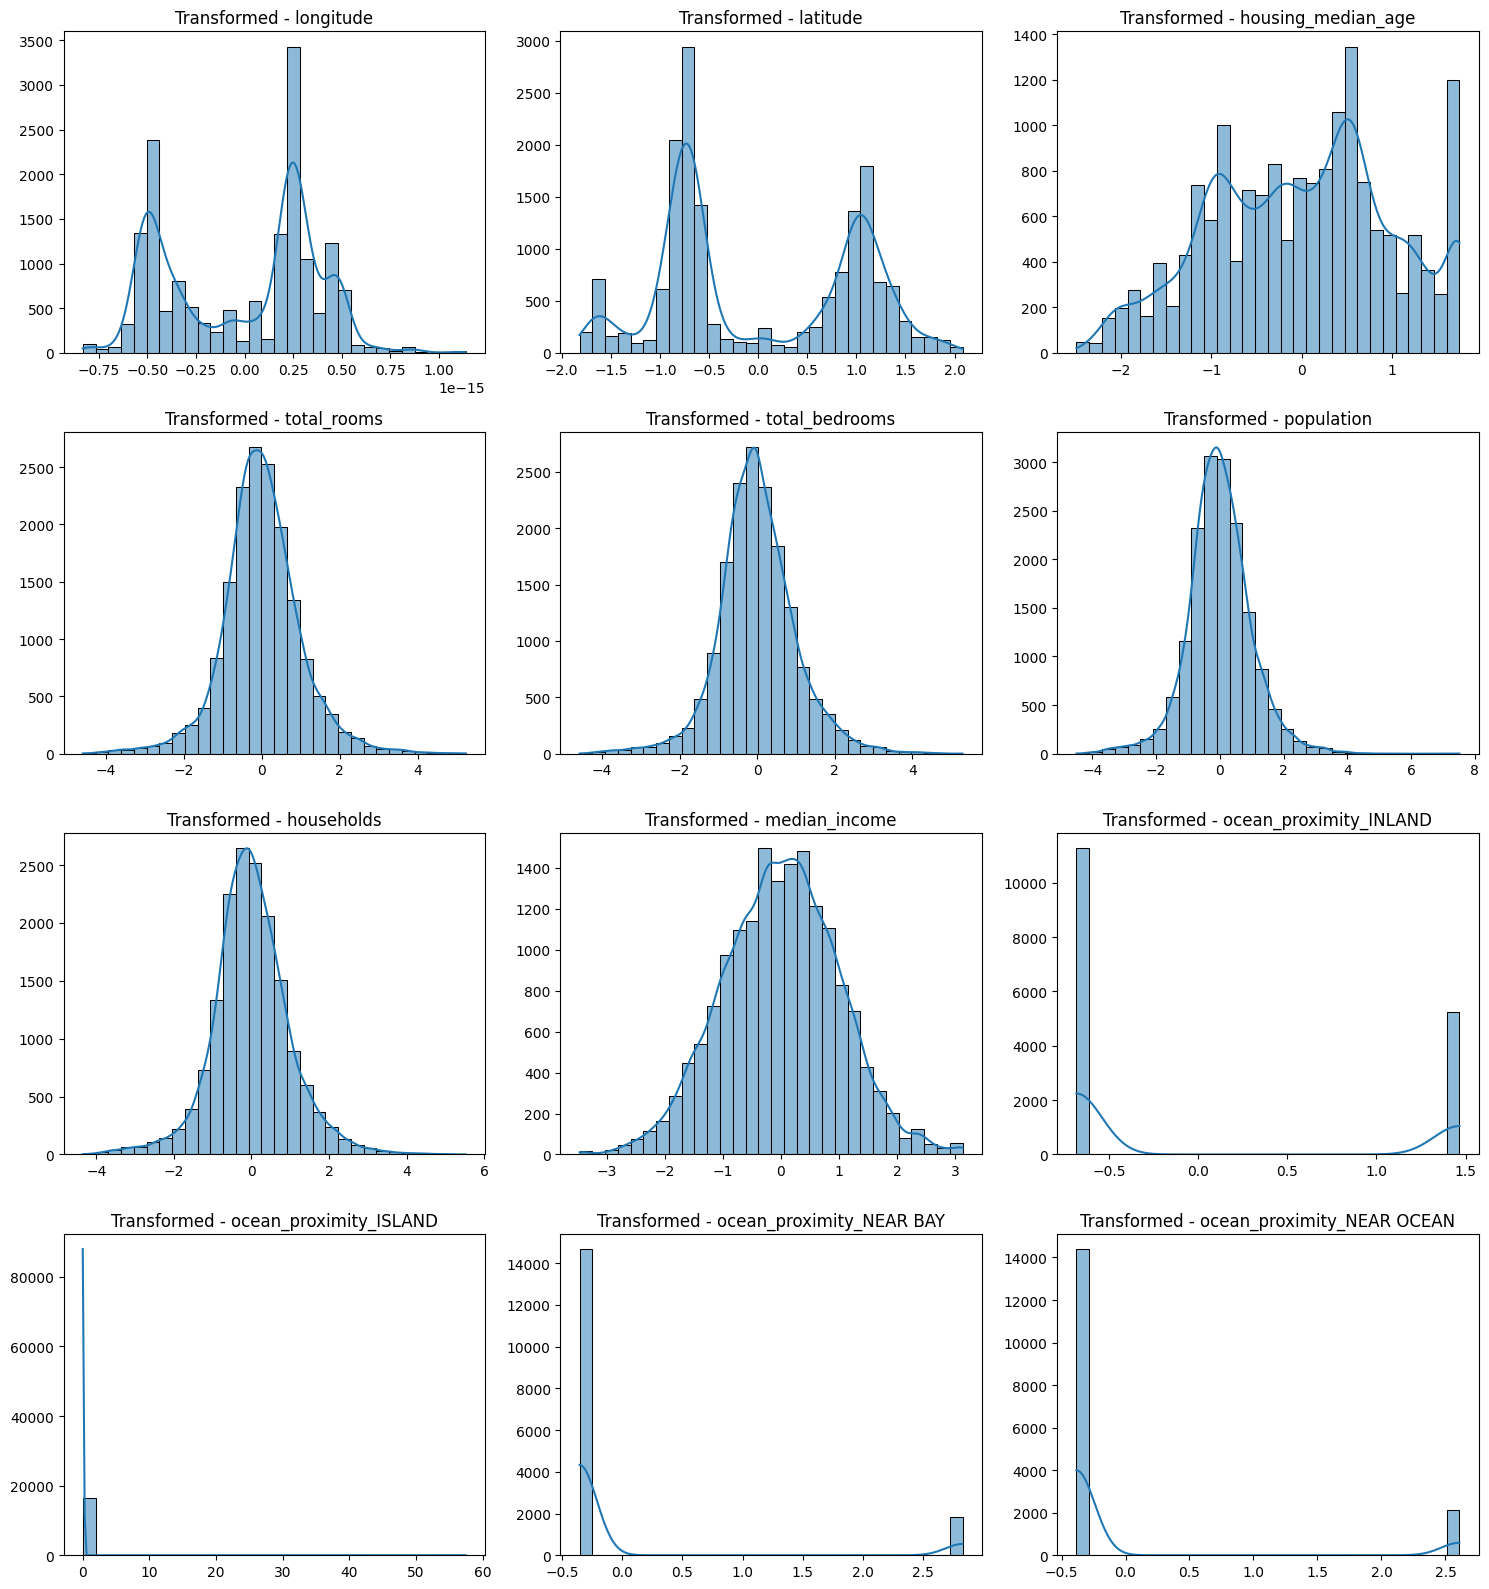

In [14]:
plot_all_histograms(X_train_transformed_df, title_prefix="Transformed - ")

In [15]:
# Inverse Boxcox
from scipy.stats import boxcox

y_train_transformed, lambda_y = boxcox(y_train)

model = LinearRegression()
model.fit(X_train_transformed, y_train_transformed)

y_pred_transformed = model.predict(X_test_transformed)

In [16]:
# (inverse Box-Cox)
def inverse_boxcox(y, lambda_):
    if lambda_ == 0:
        return np.exp(y)
    else:
        return np.power(y * lambda_ + 1, 1 / lambda_)

# original scaling of predictions
y_pred_original = inverse_boxcox(y_pred_transformed, lambda_y)

In [17]:
print("R2 Score:", r2_score(y_test, y_pred_original))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_original)))

R2 Score: 0.6487128238064692
RMSE: 68345.35406423804


In [18]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [19]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "KNN Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=15),
    "Random Forest": RandomForestRegressor(random_state=15),
    "AdaBoost": AdaBoostRegressor(random_state=15),
    "Gradient Boosting": GradientBoostingRegressor(random_state=15),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(random_state=15, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=15)
}

In [20]:
results = []

for name, model in models.items():
    model.fit(X_train_transformed, y_train_transformed)
    
    y_train_pred = model.predict(X_train_transformed)
    y_test_pred = model.predict(X_test_transformed)
    
    y_train_pred_original = inverse_boxcox(y_train_pred, lambda_y)
    y_test_pred_original = inverse_boxcox(y_test_pred, lambda_y)

    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred_original)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred_original)
    
    results.append({
        "Model": name,
        "Train_MAE": train_mae,
        "Train_RMSE": train_rmse,
        "Train_R2": train_r2,
        "Test_MAE": test_mae,
        "Test_RMSE": test_rmse,
        "Test_R2": test_r2
    })

  File "c:\Users\enes\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\enes\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\enes\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\enes\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1659
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 11
[LightGBM] [Info] Start training from score 28.168708


In [21]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="Test_R2", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
display(results_df)

,Model,Train_MAE,Train_RMSE,Train_R2,Test_MAE,Test_RMSE,Test_R2
0,XGBoost,2.179806e+04,3.262606e+04,0.920086,32103.165215,50066.611699,0.811487
1,LightGBM,2.919311e+04,4.421476e+04,0.853233,33532.966991,51087.656246,0.803720
2,Random Forest,1.244040e+04,2.061551e+04,0.968093,33723.524670,52488.171490,0.792811
3,Gradient Boosting,3.757273e+04,5.609914e+04,0.763731,39374.171359,58480.905442,0.742799
4,SVR,3.814403e+04,5.731093e+04,0.753413,39507.944404,58828.100749,0.739736
5,KNN Regressor,3.366675e+04,5.115663e+04,0.803529,42452.072759,63178.846208,0.699816
6,Linear Regression,4.764976e+04,6.789789e+04,0.653895,48094.075391,68345.354064,0.648713
7,Ridge,4.765098e+04,6.789990e+04,0.653875,48095.450484,68347.940950,0.648686
8,Decision Tree,2.383359e-10,3.641832e-10,1.000000,45961.526890,71440.542977,0.616175
9,AdaBoost,5.928817e+04,8.118762e+04,0.505149,60192.965529,82427.769407,0.489035


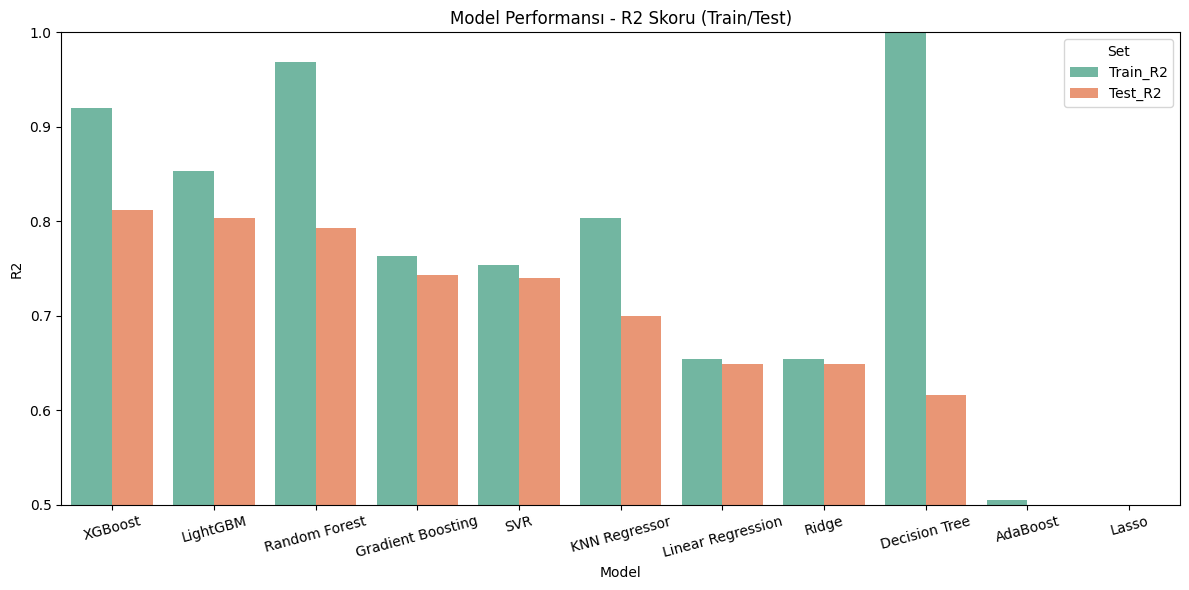

In [22]:
r2_melted = results_df.melt(id_vars="Model", value_vars=["Train_R2", "Test_R2"], 
                            var_name="Set", value_name="R2")

plt.figure(figsize=(12,6))
sns.barplot(data=r2_melted, x="Model", y="R2", hue="Set", palette="Set2")
plt.title("Model Performansı - R2 Skoru (Train/Test)")
plt.ylim(0.5, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()